In [10]:
import pandas as pd
import yaml
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
config = yaml.safe_load(open('../../configs/config.yml'))

In [12]:
def get_data(config=config):

    # get paths
    paths = config.get('paths', 'NO "PATHS" SET IN CONFIG')

    # read
    x_train = pd.read_csv("../../" + paths.get('train_values'))
    y_train = pd.read_csv("../../" + paths.get('train_labels'))

    # join
    df_train = pd.merge(x_train, y_train, on="building_id")

    return df_train

In [13]:
%%time
train = get_data(config)

CPU times: total: 1.91 s
Wall time: 2.1 s


# Drop Columns
---

In [14]:
df_train = train.drop(config.get("data_cleaning").get("columns_to_remove"), axis=1)

# Column Types
---

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 32 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [16]:
def format_dtypes(df):
    # categorical values
    cat_cols = df.select_dtypes(include='object').columns.tolist()
    df[cat_cols] = df[cat_cols].astype('category')

    return df

In [17]:
df_train = format_dtypes(df_train)

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 32 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   building_id                             260601 non-null  int64   
 1   geo_level_1_id                          260601 non-null  int64   
 2   geo_level_2_id                          260601 non-null  int64   
 3   geo_level_3_id                          260601 non-null  int64   
 4   count_floors_pre_eq                     260601 non-null  int64   
 5   age                                     260601 non-null  int64   
 6   area_percentage                         260601 non-null  int64   
 7   height_percentage                       260601 non-null  int64   
 8   land_surface_condition                  260601 non-null  category
 9   foundation_type                         260601 non-null  category
 10  roof_type                       

# Outliers
---
To handle (numeric) outliers the statistical IQR Method is used. Outliers which are filtered by this method are either replaced with the upper or the lower bound value, another option would be to simply drop them.

In [19]:
 def find_outliers_IQR(df, iqr_factor=1.5):
    """
    Identifies outliers in a given dataframe using the Interquartile Range (IQR) method.

    :param df: Pandas dataframe to be processed.
    :type df: pd.DataFrame

    :param iqr_factor: Factor to multiply the IQR by to set the bounds for outliers (default: 1.5).
    :type iqr_factor: float

    :return: Dataframe containing rows with any numerical value outside the calculated bounds.
    :rtype: pd.DataFrame
    """
    # Identify the numerical columns in the dataframe
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

    # Calculate the IQR for each numerical column
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate the lower and upper bounds for outliers
    lower_bound = Q1 - iqr_factor * IQR
    upper_bound = Q3 + iqr_factor * IQR

    # Identify the rows where any numerical value is outside the bounds
    outliers = df[
        ((df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound))
    ]

    return outliers

In [34]:
outliers = find_outliers_IQR(df_train)

In [35]:
outliers.notna().sum(axis=1)

0         1
1         0
2         0
3         1
4         3
         ..
260596    1
260597    0
260598    1
260599    2
260600    2
Length: 260601, dtype: int64

404566

In [22]:
def handle_outliers_IQR(df, ignore_cols, iqr_factor=1.5, method="soft_drop"):
    """
    Handle outliers in a mixed categorical and numerical dataframe using the IQR method. Note that this function only drops outliers based on IQR and does not consider any categorical features. It is assumed that any categorical features in the dataframe will not contribute to the detection of outliers.

    :param df: The input dataframe.
    :type df: pd.DataFrame
    :param iqr_factor: The factor to be multiplied with the IQR to determine the outlier bounds.
    :type iqr_factor: float, optional (default=1.5)
    :param method: The method to handle outliers. The options are:
        - "drop": drops the rows with outliers.
        - "cap": replaces the outliers with the upper or lower limit.
    :type method: str, optional (default="drop")
    :return: The processed dataframe with outliers handled.
    :rtype: pd.DataFrame
    """
    # Identify the numerical columns in the dataframe
    df = df.drop(ignore_cols, axis=1)
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

    # Calculate the IQR for each numerical column
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate the lower and upper bounds for outliers
    lower_bound = Q1 - iqr_factor * IQR
    upper_bound = Q3 + iqr_factor * IQR

    # Identify the rows where any numerical value is outside the bounds aka identify the outliers
    outlier_mask = (df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound)
    outlier_rows = outlier_mask.any(axis=1)

    if method == "hard_drop":
        # Drop rows with outliers
        df = df[~outlier_rows]
    elif method == "soft_drop":
        # Compute the number of outliers per row and drop rows based on the threshold (30%)
        count_outliers = outlier_mask.notna().sum(axis=1)
        drop_indices = count_outliers[count_outliers >= 30 * len(numeric_cols)].index
        df = df.drop(drop_indices)
    elif method == "replace":
        upper_limit = df[numeric_cols].mean() + 3 * df[numeric_cols].std()
        lower_limit = df[numeric_cols].mean() - 3 * df[numeric_cols].std()
        # Replace outliers with upper or lower limit
        df[numeric_cols] = np.where(df[numeric_cols] > upper_limit, upper_limit,
                                    np.where(df[numeric_cols] < lower_limit, lower_limit,
                                             df[numeric_cols]))
    else:
        raise ValueError(f"Invalid method: {method}, must be either 'drop' or 'replace'.")

    return df

Ignore binary encoded columns and also id columns which do not represent a proper numeric value.

In [23]:
binary_encoded_cols = [x for x in df_train.columns if x.startswith("has_")]
columns_to_ignore = ["building_id", "geo_level_1_id", "geo_level_2_id", "geo_level_3_id", "damage_grade", "count_floors_pre_eq", "count_families"]

In [24]:
# Dataframe without outliers
no_outliers = handle_outliers_IQR(df_train, method="hard_drop", ignore_cols=columns_to_ignore+binary_encoded_cols)

Plot difference between cleaned data and original data

In [25]:
%%time
outliers = df_train.assign(outliers_filter="no")
no_outliers = no_outliers.assign(outliers_filter="yes")
data = pd.concat([outliers, no_outliers])

CPU times: total: 109 ms
Wall time: 128 ms


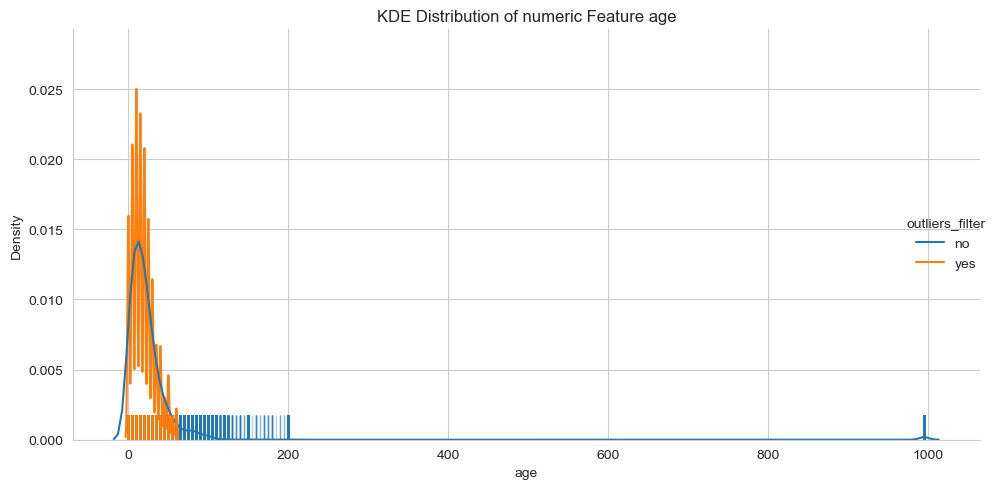

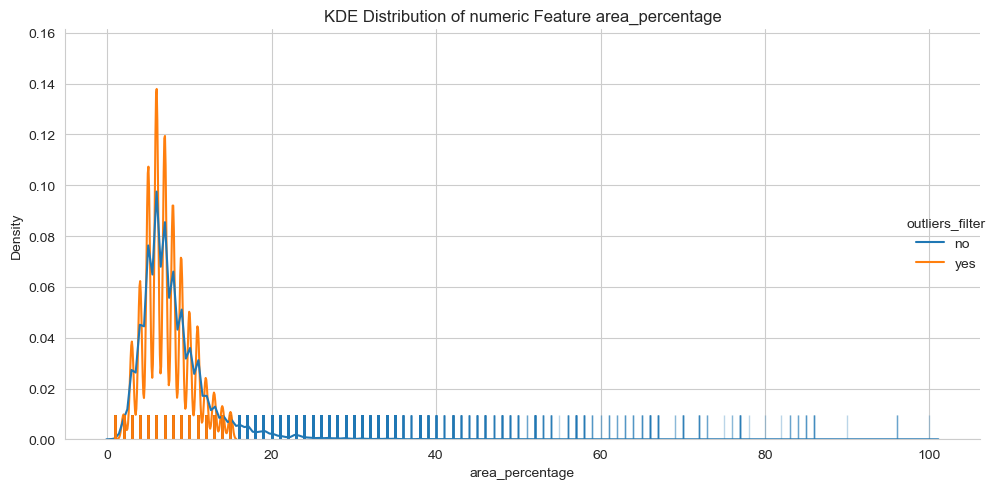

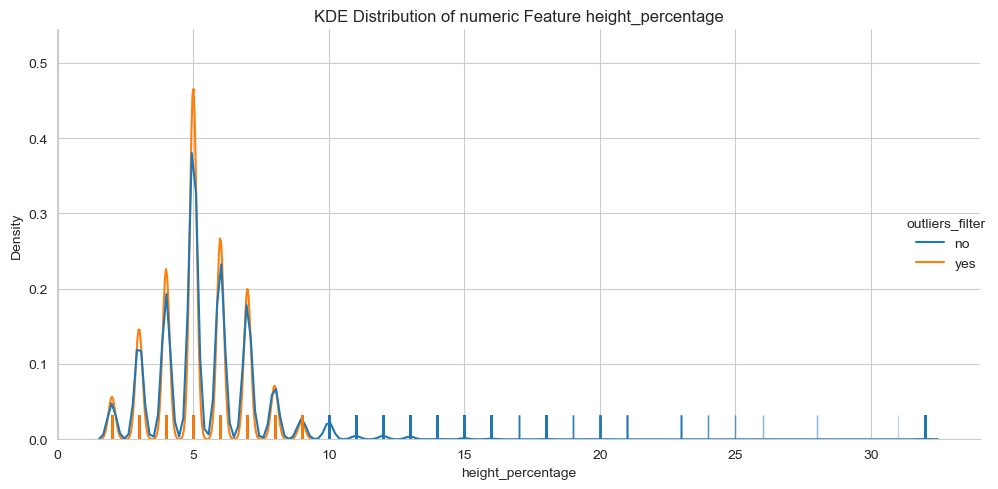

CPU times: total: 59.2 s
Wall time: 1min 1s


In [26]:
%%time
numeric_cols = data.select_dtypes(include=np.number).columns.tolist()
# plot kde
for feature in [col for col in numeric_cols if col not in (columns_to_ignore+binary_encoded_cols)]:
    g = sns.displot(data=data, x=feature, kind="kde", rug=True, rug_kws={"color": "g", "alpha": 0.3, "linewidth": 1, "height":0.06}, hue="outliers_filter",)
    g.figure.set_figwidth(10)
    g.figure.set_figheight(5)
    g.set(title=f"KDE Distribution of numeric Feature {feature}")
    plt.tight_layout()
    plt.show()

# Summary

In [27]:
%%time
def clean_data(df, config, ignore_cols, outlier_method):
    """
    Cleans the input pandas DataFrame by dropping unnecessary columns, formatting column data types, and handling outliers.

    :param df: pandas DataFrame to be processed
    :type df: pandas.DataFrame
    :param config: configparser object containing configuration settings
    :type config: configparser.ConfigParser
    :param ignore_cols: list of column names to ignore when handling outliers (default: None)
    :type ignore_cols: list or None
    :param outlier_method: The method to handle outliers. The options are:
        - "drop": drops the rows with outliers.
        - "cap": replaces the outliers with the upper or lower limit.
    :type outlier_method: str
    :return: cleaned pandas DataFrame
    :rtype: pandas.DataFrame
    """
    # Drop unnecessary columns
    drop_cols = config.get("data_cleaning", "NO DATA CLEANING DEFINED").get("columns_to_remove")
    df = df.drop(drop_cols, axis=1)
    # Format column types
    df = format_dtypes(df)
    # Handle outliers
    df = handle_outliers_IQR(df, ignore_cols=ignore_cols, method=outlier_method)
    return df

CPU times: total: 0 ns
Wall time: 0 ns


In [28]:
%%time
cl_df_train = clean_data(train, config=config, ignore_cols=columns_to_ignore+binary_encoded_cols, outlier_method="replace")
cl_x_train = cl_df_train.drop("damage_grade", axis=1)
cl_y_train = cl_df_train["damage_grade"]

KeyError: "['damage_grade'] not found in axis"

In [29]:
df_train.describe()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,damage_grade
count,2.606010e+05,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,...,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,5.256755e+05,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,...,0.254988,0.085011,0.042590,0.015859,0.014985,0.983949,0.111880,0.064378,0.033626,2.238272
std,3.045450e+05,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,...,0.435855,0.278899,0.201931,0.124932,0.121491,0.418389,0.315219,0.245426,0.180265,0.611814
min,4.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.611900e+05,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000
50%,5.257570e+05,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000
75%,7.897620e+05,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000
max,1.052934e+06,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,1.000000,1.000000,1.000000,3.000000


In [30]:
cl_df_train.describe()

,age,area_percentage,height_percentage
count,260601.000000,260601.000000,260601.000000
mean,22.546570,7.903841,5.406954
std,25.555707,3.737762,1.774089
min,0.000000,1.000000,2.000000
25%,10.000000,5.000000,4.000000
50%,15.000000,7.000000,5.000000
75%,30.000000,9.000000,6.000000
max,247.232838,21.194743,11.189620
